In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from platon.transit_depth_calculator import TransitDepthCalculator
from platon.constants import M_jup, R_jup, R_sun

# Figure style
FIG_WIDE = (11, 8)
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = {
    # xticks
    "xtick.top": False,
    "xtick.direction": "out",
    "xtick.major.size": 5,
    "xtick.minor.visible": False,
    # yticks
    "ytick.right": False,
    "ytick.direction": "out",
    "ytick.major.size": 5,
    "ytick.minor.visible": False,
    # tick labels
    "axes.formatter.useoffset": False,
    # pallete
    "axes.prop_cycle": mpl.cycler(
        color=[
            "#fdbf6f",  # Yellow
            "#ff7f00",  # Orange
            "#a6cee3",  # Cyan
            "#1f78b4",  # Blue
            "plum",
            "#956cb4",  # Purple
            "mediumaquamarine",
            "#029e73",  # Green
            "slategray",
        ]
    ),
}

plt.rcParams.update(params)

In [2]:
%matplotlib inline

In [3]:
# All inputs and outputs for PLATON are in SI

# Star
R_s = 1.152 * R_sun
T_eff = 5920
T_spot = 2200
spot_cov_frac = 0.022

# Planet
M_p = 1.92 * M_jup
R_p = 1.247 * R_jup
T_eq = 2027

# Bin
wav_min, wav_max, wav_diff = 3_100, 9_500, 200 # Å
wbins = np.array([[wav, wav + wav_diff] for wav in np.arange(wav_min, wav_max, wav_diff)]) * 1e-10 # Å -> m

# The initializer loads all data files.  Create a TransitDepthCalculator
# object and hold on to it
calculator = TransitDepthCalculator(method="xsec") #"ktables" for correlated k
calculator_stell_act = TransitDepthCalculator(method="xsec")
calculator_binned = TransitDepthCalculator(method="xsec")
calculator_binned_stell_act = TransitDepthCalculator(method="xsec")

# Bin data
calculator_binned.change_wavelength_bins(wbins)
calculator_binned_stell_act.change_wavelength_bins(wbins)


def compute(
    calc, R_s, M_p, R_p, T_eq,
    logZ=0, CO_ratio=0.53,
    T_star=None, T_spot=None,
    spot_cov_frac=None,
    stellar_blackbody=True,
    full_output=True
    ):
    # compute_depths is fast once data files are loaded
    return calc.compute_depths(
        R_s, M_p, R_p, T_eq,
        logZ=0, CO_ratio=0.53,
        T_star=T_eff, T_spot=T_spot, spot_cov_frac=spot_cov_frac, stellar_blackbody=stellar_blackbody,
        full_output=full_output,
    ) # wavelengths, depths, info_dict 

######
# Load
######
wavelengths_stell_act, depths_stell_act, data_info_stell_act = compute(
    calculator_stell_act, R_s, M_p, R_p, T_eq,
    T_star=T_eff, T_spot=T_spot, spot_cov_frac=spot_cov_frac,
)
wavelengths_binned_stell_act, depths_binned_stell_act, data_info_binned_stell_act = compute(
    calculator_binned_stell_act, R_s, M_p, R_p, T_eq,
    T_star=T_eff, T_spot=T_spot, spot_cov_frac=spot_cov_frac,
)
wavelengths, depths, data_info = compute(
    calculator, R_s, M_p, R_p, T_eq,
)
wavelengths_binned, depths_binned, data_info_binned = compute(
    calculator_binned, R_s, M_p, R_p, T_eq,
)

# IMACS
wav, tspec_combined, tspec_combined_unc = np.genfromtxt(
    f"./tspec_c.txt", unpack=True
)

(12000.0, 15000.0)

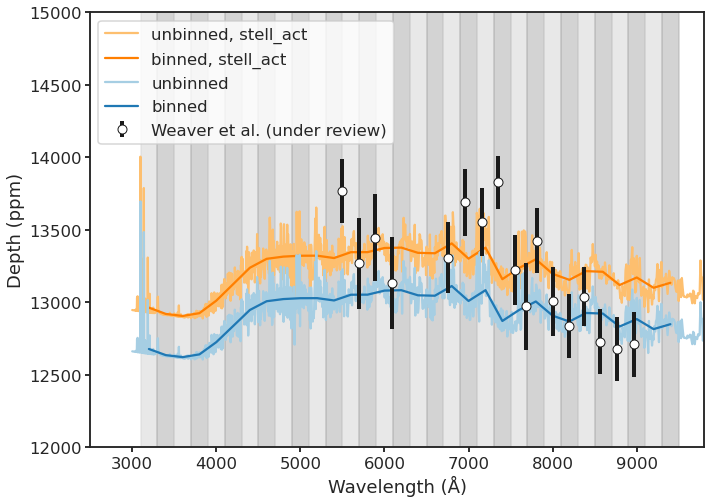

In [4]:
fig, ax = plt.subplots(figsize=FIG_WIDE)


ax.plot(
    wavelengths_stell_act*1e10, depths_stell_act*1e6, label="unbinned, stell_act"
)
ax.plot(
    wavelengths_binned_stell_act*1e10, depths_binned_stell_act*1e6, label="binned, stell_act"
)
ax.plot(
    wavelengths*1e10, depths*1e6, label="unbinned"
)
ax.plot(
    wavelengths_binned*1e10, depths_binned*1e6, label="binned"
)

# IMACS
ax.errorbar(
    wav,
    tspec_combined,
    yerr=tspec_combined_unc,
    c="w",
    mec="k",
    fmt="o",
    zorder=10,
    label="Weaver et al. (under review)",
    ecolor="k",
    lw=4,
)


colors = ["lightgrey", "darkgrey"]
for i, wbin in enumerate(wbins * 1e10):
    ax.axvspan(wbin[0], wbin[1], color=colors[i % 2], alpha=0.5)

ax.legend()
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel("Depth (ppm)")
ax.set_xlim(np.array([2_500, 9_800]))
ax.set_ylim(12_000, 15_000)